In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

sys.path.append('../src') # move relative path to source code
from Models import MindReader
from methods import histogram_equalization, scattera

# Load data

In [3]:
# this path determines where downloaded data will be stored
dataset_path = os.environ.get("DATASETS")
dataset_name = 'ecephys_cache_dir'
manifest_path = os.path.join(dataset_path, dataset_name, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
session_id = 791319847
session = cache.get_session_data(session_id)
scene_presentations = session.get_stimulus_table("natural_scenes")

spikes = session.presentationwise_spike_times(
    stimulus_presentation_ids=scene_presentations.index.values,
    unit_ids=session.units.index.values
)

# Load and setup: npa and targets
* NPA: neural population activity, aggregated (summed) action potentials across stimulus time
* Targets: integers indicating different natural images

In [4]:
spikes = spikes.groupby(["stimulus_presentation_id", "unit_id"]).count()

design = pd.pivot_table(
    spikes, 
    values='time_since_stimulus_presentation_onset', 
    index="stimulus_presentation_id", 
    columns="unit_id", 
    fill_value=0.0,
    aggfunc=np.sum
)
targets = scene_presentations.loc[design.index.values, "frame"]

design_arr = design.values.astype(float)
targets_arr = targets.values.astype(int) + 1 # add +1 since one class is -1 somehow
labels = np.unique(targets_arr)

In [6]:
# preprocess input (standardise)
design_arr -= np.mean(design_arr)
design_arr /= np.std(design_arr)

# lowest target value is -1, shift so that range starts at 0
targets_arr -= np.min(targets_arr)
num_categories = max(targets_arr)+1 # size of NN output

# Initialise MindReader

In [7]:
model = MindReader(num_categories)

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),  # Optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), # Loss func
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()], # Metrics to monitor
)

# Build (by specifying input_shape) and summarize model
mb_size = 32
input_shape = [mb_size,design_arr.shape[-1]]
model.build(input_shape)
model.summary()

Model: "mind_reader"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  66164     
_________________________________________________________________
softmax (Softmax)            multiple                  0         
Total params: 66,164
Trainable params: 66,164
Non-trainable params: 0
_________________________________________________________________


# Train MindReader

In [8]:
model.fit(x=design_arr,y=targets_arr,batch_size=32,epochs=15,validation_split=0.1,shuffle=True)
print("CHANCE: {}".format(1/labels.size))

Epoch 1/15
168/168 [==============================] - 1s 5ms/step - loss: 4.9950 - sparse_categorical_accuracy: 0.0311 - val_loss: 4.0036 - val_sparse_categorical_accuracy: 0.1294
Epoch 2/15
168/168 [==============================] - 0s 1ms/step - loss: 3.3679 - sparse_categorical_accuracy: 0.3138 - val_loss: 3.0784 - val_sparse_categorical_accuracy: 0.3832
Epoch 3/15
168/168 [==============================] - 0s 2ms/step - loss: 2.3332 - sparse_categorical_accuracy: 0.6166 - val_loss: 2.4948 - val_sparse_categorical_accuracy: 0.5193
Epoch 4/15
168/168 [==============================] - 0s 1ms/step - loss: 1.6353 - sparse_categorical_accuracy: 0.7761 - val_loss: 2.1316 - val_sparse_categorical_accuracy: 0.5798
Epoch 5/15
168/168 [==============================] - 0s 1ms/step - loss: 1.1941 - sparse_categorical_accuracy: 0.8491 - val_loss: 1.8825 - val_sparse_categorical_accuracy: 0.6286
Epoch 6/15
168/168 [==============================] - 0s 1ms/step - loss: 0.9289 - sparse_categorica

# Choose inputs as basis for investigation

In [69]:
# choose a class to aggregate neural activity over
class_choice =  100 # 49 is diff
class_idxs = np.where(targets_arr == class_choice) # Each class has been shown -- 50 -- times

# make tf.Variable so that we can track gradients
salient_input = tf.Variable(design_arr[class_idxs], dtype=float)

tensorflow.python.ops.resource_variable_ops.ResourceVariable

# Test saliency map
Because the MindReader is just a single dense layer prior to a softmax, we can easily calculate the saliency map by hand. The saliency map differentiates the output score (prior to softmax) for a chosen output class wrt. each element of the input. This gives the dense weight matrix vector leading to that output class. NB! The saliency map is independent of the input and score when the model is linear (only dependent on the weight matrix. or: the saliency map is the weight matrix). We show this explicitly here:

In [153]:
chosen_out_class = 4
grads, category = model.saliency(salient_input, out_class)

assert sum(grads[0]) == sum(model.layers[0].weights[0][:,out_class]), \
"Saliency map should be equal a vector of the weight matrix"

# Plot saliency maps spatially

In [154]:
salient_input = tf.Variable(design_arr[class_idxs], dtype=float)
grads, category = model.saliency(salient_input)

In [167]:
np_grads = grads.numpy()
aggregated_grads = np_grads[0] # model is linear, so every input example produces identical saliency maps

hadamard_grads = np_grads * salient_input.numpy()
hadamard_grads = np.mean(hadamard_grads,axis=0)

In [168]:
def normalise(arr):
    # normalise to [0,1]
    norm_arr = arr.copy() # deep copy
    norm_arr -= np.min(norm_arr)
    norm_arr /= np.max(norm_arr)
    return norm_arr

aggregated_grads = normalise(aggregated_grads)
hadamard_grads = normalise(hadamard_grads)

<IPython.core.display.Javascript object>


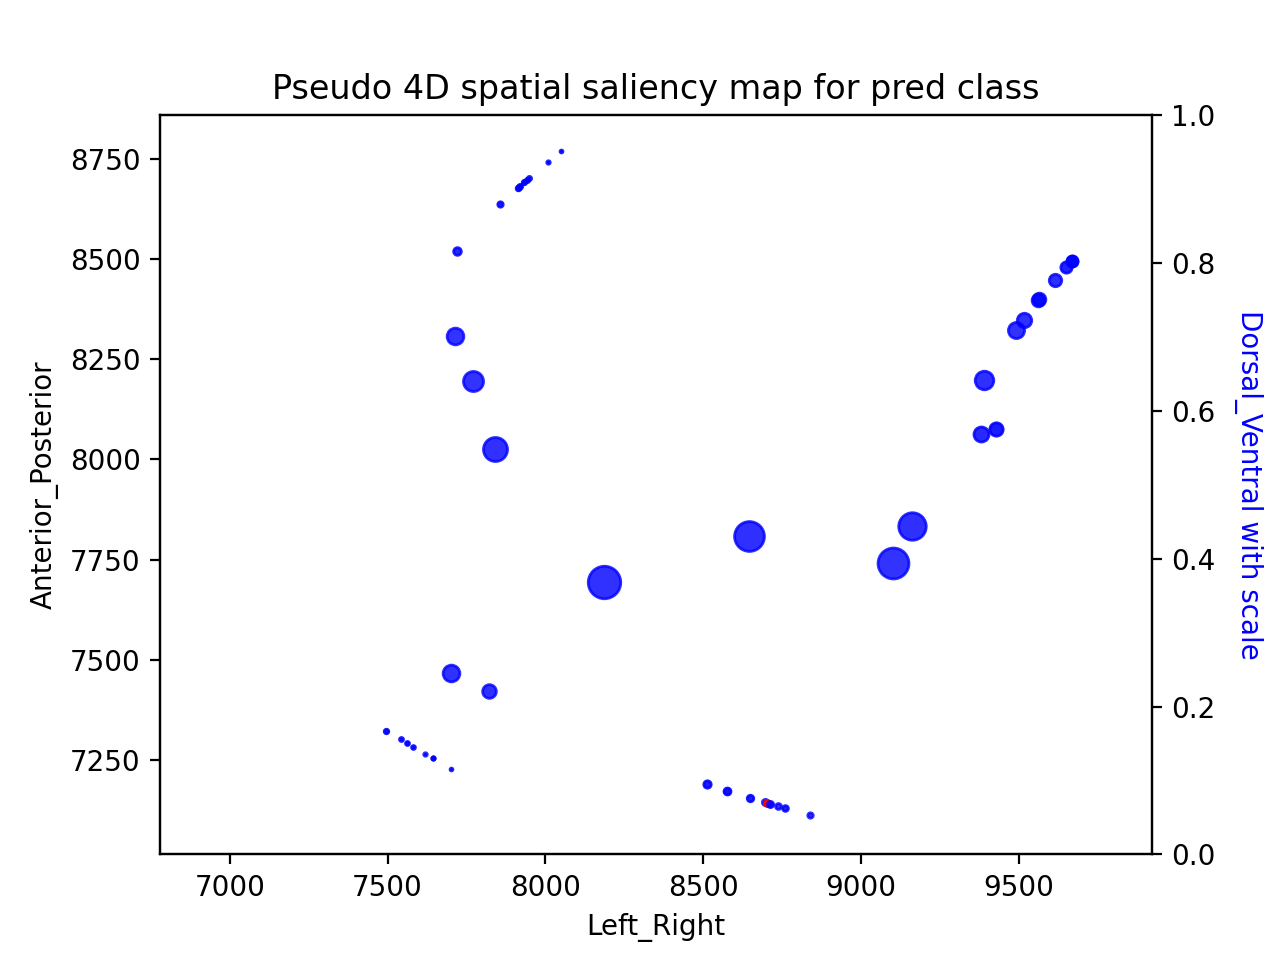

#spikes_max=1.0, ID=532
#spikes_avg=0.6575449705123901, #spikes_std=0.12277653068304062


In [184]:
plt.close()
fig, ax = plt.subplots(1)#, sharex='col', sharey='row', gridspec_kw={'wspace': 0})

# orthogonal data
x=session.units['left_right_ccf_coordinate']
y=session.units['anterior_posterior_ccf_coordinate']
# depth dim
dv=histogram_equalization(session.units['dorsal_ventral_ccf_coordinate'])
s=np.exp(5*dv)

c=['blue']*len(x) # choose color

alpha=aggregated_grads.copy()
alpha[alpha < 0.8] = 0
c[np.argmax(alpha)]='red' # color most active neuron red
c = np.asarray(c)

ax = scattera(ax,x,y,s=s,c=c,alpha=alpha)
ax.set_xlabel('Left_Right')
ax.set_ylabel('Anterior_Posterior')
ax.set_title('Pseudo 4D spatial saliency map for pred class')
ax.twinx().set_ylabel('Dorsal_Ventral with scale',rotation=270,labelpad=17,color='blue')

# 349 & 352 almost always...?
print('#spikes_max={}, ID={}'.format(aggregated_grads[np.argmax(alpha)],np.argmax(alpha)))
print('#spikes_avg={}, #spikes_std={}'.format(np.mean(aggregated_grads),np.std(aggregated_grads)))

<IPython.core.display.Javascript object>


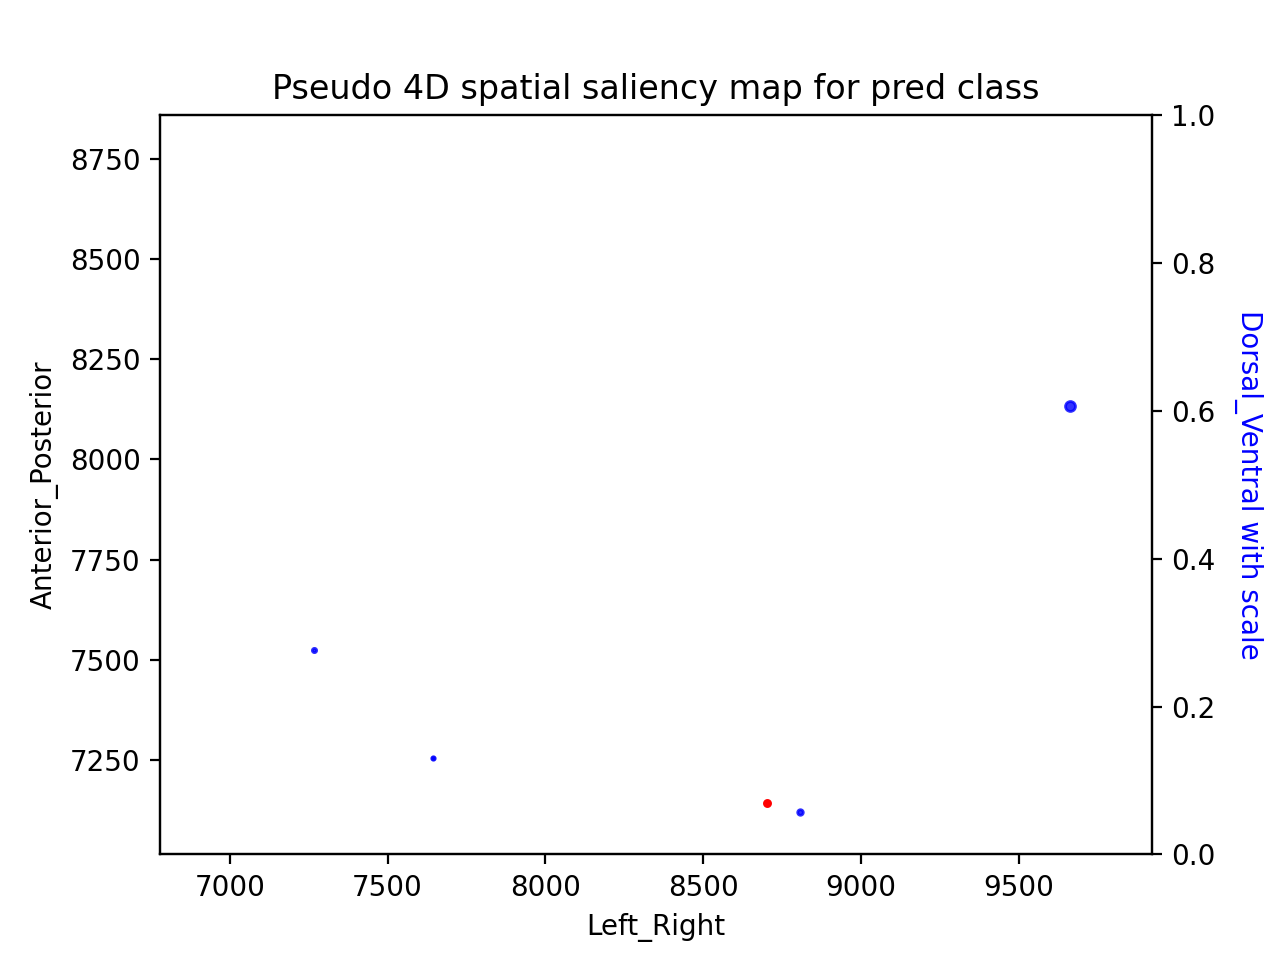

#spikes_max=1.0, ID=532
#spikes_avg=0.6575449705123901, #spikes_std=0.12277653068304062


In [187]:
plt.close()
fig, ax = plt.subplots(1)#, sharex='col', sharey='row', gridspec_kw={'wspace': 0})

# orthogonal data
x=session.units['left_right_ccf_coordinate']
y=session.units['anterior_posterior_ccf_coordinate']
# depth dim
dv=histogram_equalization(session.units['dorsal_ventral_ccf_coordinate'])
s=np.exp(5*dv)

c=['blue']*len(x) # choose color

alpha=hadamard_grads.copy()
alpha[alpha < 0.8] = 0
c[np.argmax(alpha)]='red' # color most active neuron red
c = np.asarray(c)

ax = scattera(ax,x,y,s=s,c=c,alpha=alpha)
ax.set_xlabel('Left_Right')
ax.set_ylabel('Anterior_Posterior')
ax.set_title('Pseudo 4D spatial saliency map for pred class')
ax.twinx().set_ylabel('Dorsal_Ventral with scale',rotation=270,labelpad=17,color='blue')

# 349 & 352 almost always...?
print('#spikes_max={}, ID={}'.format(aggregated_grads[np.argmax(alpha)],np.argmax(alpha)))
print('#spikes_avg={}, #spikes_std={}'.format(np.mean(aggregated_grads),np.std(aggregated_grads)))

<IPython.core.display.Javascript object>


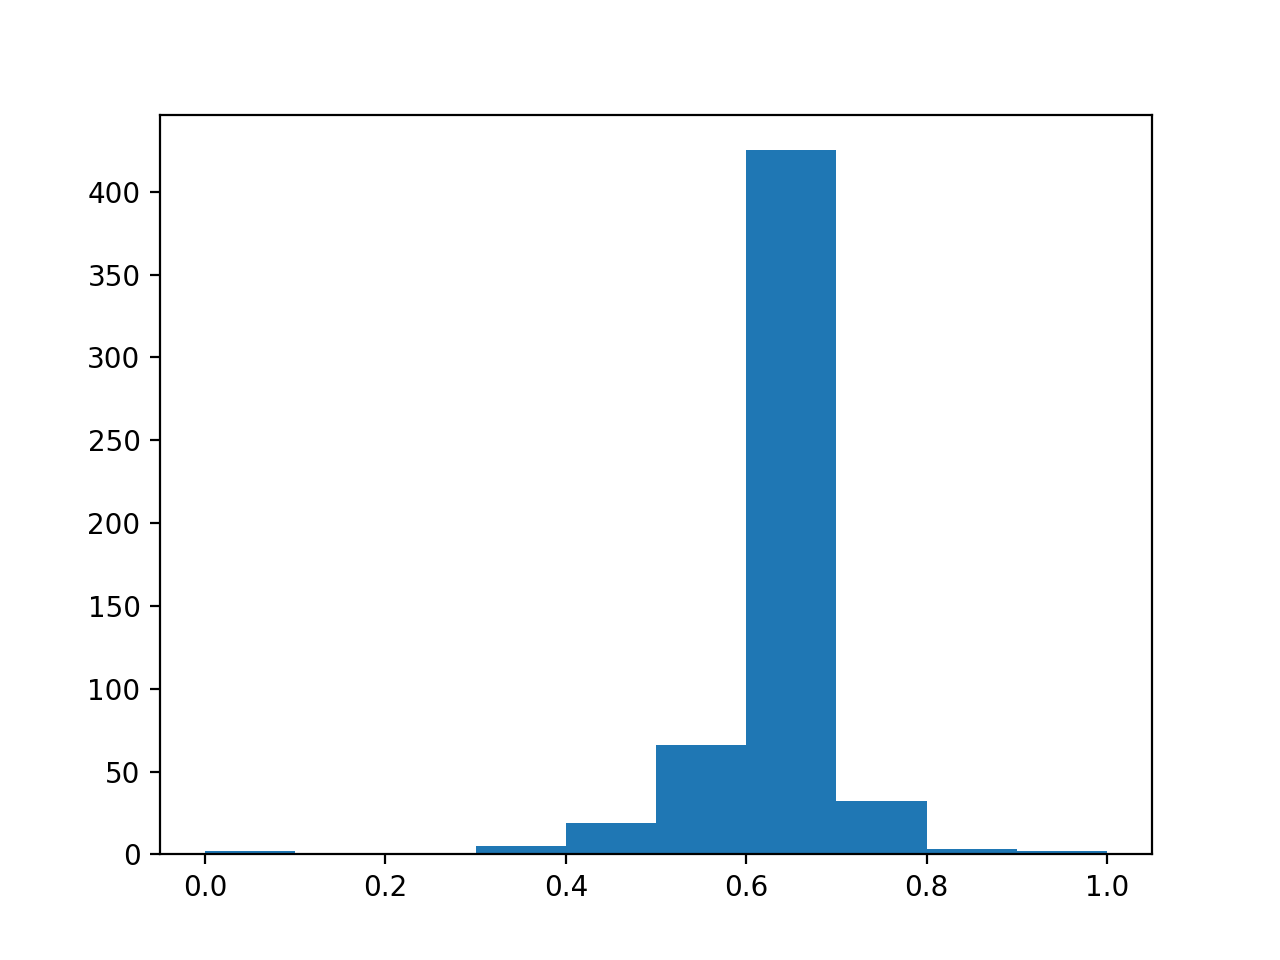

(array([  2.,   1.,   0.,   5.,  19.,  66., 425.,  32.,   3.,   2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

In [188]:
plt.close()
plt.hist(hadamard_grads)

<IPython.core.display.Javascript object>


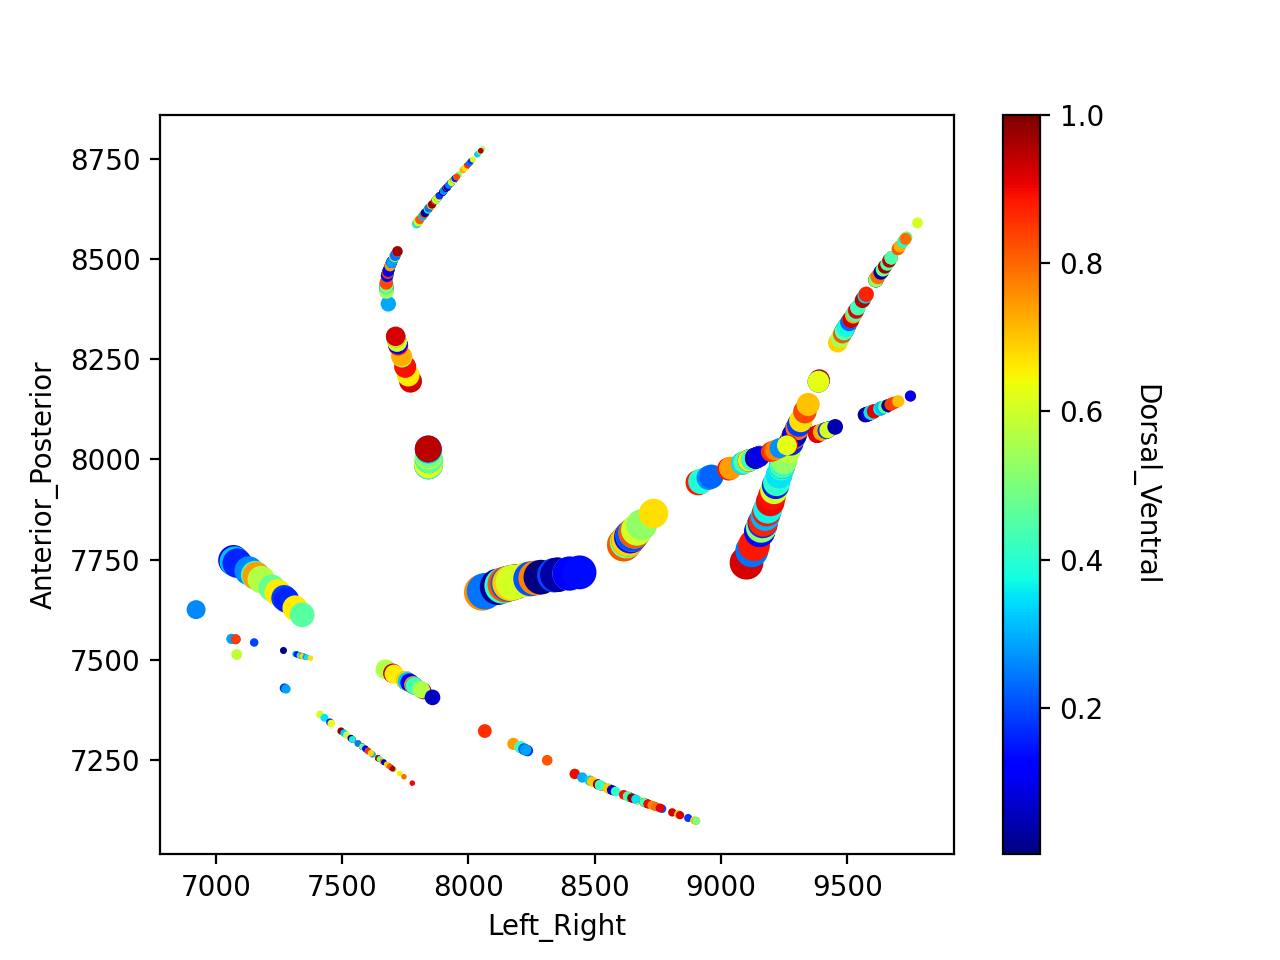

Text(0, 0.5, 'Dorsal_Ventral')

In [189]:
plt.close()
fig, ax = plt.subplots(1)
sc = ax.scatter(x=session.units['left_right_ccf_coordinate'], \
           y=session.units['anterior_posterior_ccf_coordinate'], \
           s=s, \
           c=histogram_equalization(aggregated_grads), \
           cmap='jet')
ax.set_xlabel('Left_Right')
ax.set_ylabel('Anterior_Posterior')
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Dorsal_Ventral', rotation=270, labelpad=20)